# Reto -> Entrega 2 Clasificación-ensambles
# Alumno: Luis José Navarrete Baduy, Rodrigo López Aguilera
# Matrícula: A01793919, A01793071
# Profesor: Maria de la Paz Rico
# Fecha: 18 de noviembre del 2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, validation_curve, learning_curve
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from imblearn.pipeline import make_pipeline
from imblearn.metrics import geometric_mean_score

In [2]:
df = pd.read_csv('../data/data_subterraneos_clean.csv', encoding='ISO-8859-1')
# Cambiando los valores de la variable SEMAFORO
semaforo_dict = {'Verde': 1, 'Rojo': 2, 'Amarillo': 3}
df['SEMAFORO'] = df['SEMAFORO'].replace(semaforo_dict)
df.head()

,LONGITUD,LATITUD,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,N_NO3_mg/L,CALIDAD_ALC_Alta,CALIDAD_ALC_Baja,...,CUMPLE_CON_CR_SI,CUMPLE_CON_HG_NO,CUMPLE_CON_HG_SI,CUMPLE_CON_PB_NO,CUMPLE_CON_PB_SI,CUMPLE_CON_MN_NO,CUMPLE_CON_MN_SI,CUMPLE_CON_FE_NO,CUMPLE_CON_FE_SI,SEMAFORO
0,-102.288010,22.366850,204.920,532.0,342.0,1.8045,120.7190,1.449803,1,0,...,1,0,1,0,1,0,1,0,1,2
1,-110.244800,23.451380,309.885,1841.0,1179.0,0.2343,476.9872,15.672251,1,0,...,1,0,1,0,1,0,1,0,1,2
2,-110.220670,23.464930,224.475,570.3,554.8,0.2756,201.8784,8.555740,1,0,...,1,0,1,0,1,0,1,0,1,2
3,-109.907306,22.890500,350.760,2253.3,1160.2,0.5607,269.1712,27.600998,1,0,...,1,0,1,0,1,0,1,0,1,2
4,-110.054722,23.824722,332.605,1703.0,1017.8,0.5088,559.0214,0.143061,1,0,...,1,0,1,0,1,1,0,1,0,2


In [3]:
target = ['SEMAFORO']
features = [v for v in df.columns.values.tolist() if v not in target]

In [4]:
# Obtener las variables mas relevantes utilizando RFE
forest = RandomForestClassifier()
selector = RFE(forest, n_features_to_select=20)
selector.fit(df[features], np.ravel(df[target]))

RFE(estimator=RandomForestClassifier(), n_features_to_select=20)

In [5]:
# Variables mas relevantes para la clasificación
relevant_features = selector.get_feature_names_out().tolist()
print(relevant_features)

['LONGITUD', 'LATITUD', 'FLUORUROS_mg/L', 'DUR_mg/L', 'N_NO3_mg/L', 'CALIDAD_FLUO_Alta', 'CALIDAD_COLI_FEC_Contaminada', 'CALIDAD_N_NO3_No apta como FAAP', 'CALIDAD_AS_No apta como FAAP', 'CALIDAD_CR_Potable - Excelente', 'CUMPLE_CON_FLUO_NO', 'CUMPLE_CON_FLUO_SI', 'CUMPLE_CON_CF_NO', 'CUMPLE_CON_CF_SI', 'CUMPLE_CON_NO3_NO', 'CUMPLE_CON_NO3_SI', 'CUMPLE_CON_AS_NO', 'CUMPLE_CON_AS_SI', 'CUMPLE_CON_CR_NO', 'CUMPLE_CON_PB_SI']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df[relevant_features], df[target], test_size=0.15, random_state=42, stratify=df[target])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(513, 20) (91, 20) (513, 1) (91, 1)


In [7]:
decision_tree = DecisionTreeClassifier()
forest = RandomForestClassifier()

In [10]:
def my_accuracy(y_real, y_pred):
    vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()
    return (vp + vn) / (vp + fp + fn + vn)

def my_precision(y_real, y_pred):
    vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()
    if vp + fp == 0:
        return 0
    return vp / (vp + fp)

def my_recall(y_real, y_pred):
    vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()
    if vp + fn == 0:
        return 0
    return vp / (vp + fn)

def my_f1score(y_real, y_pred):
    vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()
    return 2 * vp / (2 * vp + fp + fn)

def my_gmean(y_real, y_pred):
    vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()

    recall = vp / (vp + fn)
    especificidad = vn / (vn+fp)

    gmean = np.sqrt(recall * especificidad)

    return gmean

In [11]:
def mi_LearningCurvePlot(train_sizes, train_scores, val_scores, title=None, xlabel=None, ylabel=None):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Gráfica las curvas de aprendizaje incluyendo una región indicando la desviación estándar.
    plt.figure(figsize=(7,6))    
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    
    if title:
        plt.title(title)
    
    if xlabel:
        plt.xlabel(xlabel)
    
    if ylabel:
        plt.ylabel(ylabel)
        
    plt.legend(loc='lower left')
    plt.show()

In [9]:
models = [decision_tree, forest]
names = ['Decision Tree', 'Random Forest']
cross_validation = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
results = list()
metrics = {
    'accuracy': make_scorer(my_accuracy),
    'precision': make_scorer(my_precision),
    'recall': make_scorer(my_recall),
    'f1_score': make_scorer(my_f1score),
    'gmean': make_scorer(my_gmean)
}
# metrics = ['accuracy']
# scores = cross_validate(forest, X_train, y_train, scoring=metrics, cv=cross_validation, n_jobs=-1)
# scores
print(f'Model\t\t\tAccuracy Precision Recall F1 Score G-mean')
for i in range(len(models)):
    scores = cross_validate(models[i], X_train, y_train, scoring=metrics, cv=cross_validation, n_jobs=-1)
    results.append(scores)
    print("%-20s\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f" % (
        names[i],
        np.mean(scores['test_accuracy']), 
        np.mean(scores['test_precision']),
        np.mean(scores['test_recall']),
        np.mean(scores['test_f1_score']),
        np.mean(scores['test_gmean'])  
    ))

Model			Accuracy Precision Recall F1 Score G-mean
Decision Tree       	0.9838	0.9857	0.9743	0.9798	0.9821
Random Forest       	0.9903	0.9768	1.0000	0.9882	0.9918


In [12]:
def evaluateGridModel(grid, score):    
    print('Best value of {} obtained from best combination of parameters: {:.5f}'.format(score, grid.best_score_))
    print('Best combination of parameters:', grid.best_params_)
    print('Metric:', grid.scoring)

def evaluate_metrics(model, X_train, y_train, X_val, y_val, metric):
  model.fit(X_train, y_train)
  
  model.fit(X_train,y_train)
  yhat = model.predict(X_val)

  if metric == 'accuracy':
    print('Accuracy score: %.4f' % model.score(X_val, y_val))
  
  if metric == 'precision':
    print('Precision score: %.4f' % my_precision(y_val, yhat))

  if metric == 'recall':  
    print('Recall score: %.4f' % my_recall(y_val, yhat))
  
  if metric == 'f1':
    print('F1 score: %.4f' % my_f1score(y_val, yhat))
  
  if metric == 'gmean':
    print('Gmean score: %.4f' % my_gmean(y_val, yhat))

In [66]:
dtc_model = DecisionTreeClassifier()

parameters = {'ccp_alpha': [0.001, 0.01, 0.1, 0.99],
                'criterion': ['gini', 'entropy', 'log_loss'],
                'max_depth': [3,4,5,6,7,8,9,10,15,20],
                'min_samples_split': [2,3,4,5,6,7,8,9,10,15,20],
                'class_weight': [None, 'balanced']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

grid_dtc = GridSearchCV(estimator=dtc_model,
                    param_grid=parameters,
                    cv=cv,
                    scoring=make_scorer(my_precision),
                    n_jobs=-1)

grid_dtc.fit(X_train, np.ravel(y_train))

evaluateGridModel(grid_dtc, 'precision')

Best value of precision obtained from best combination of parameters: 0.98590
Best combination of parameters: {'ccp_alpha': 0.001, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 2}
Metric: make_scorer(my_precision)


In [67]:
rfc_model = RandomForestClassifier()

parameters = {'ccp_alpha': [0.001, 0.01, 0.1, 0.99],
                'criterion': ['gini', 'entropy', 'log_loss'],
                'max_depth': [3,4,5,6,7,8,9,10],
                'min_samples_split': [2,3,4,5,6,7,8,9,10],
                'class_weight': [None, 'balanced', 'balanced_subsample']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

grid_rfc = GridSearchCV(
  estimator=rfc_model,
  param_grid=parameters,
  cv=cv,
  scoring=make_scorer(my_recall),
  n_jobs=-1
) # parallel jobs in CPU

grid_rfc.fit(X_train, np.ravel(y_train))

evaluateGridModel(grid_rfc, 'recall')

Best value of recall obtained from best combination of parameters: 1.00000
Best combination of parameters: {'ccp_alpha': 0.001, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 3}
Metric: make_scorer(my_recall)


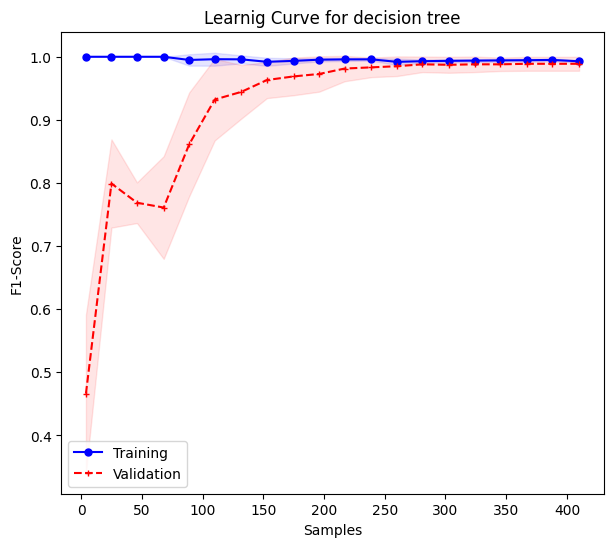

Precision score: 1.0000


In [27]:
delta_a = np.linspace(0.01, 1, 20)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
model = DecisionTreeClassifier(
    ccp_alpha=0.001,
    criterion='entropy',
    max_depth=6,
    min_samples_split=2
)
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train,
    np.ravel(y_train),
    train_sizes=delta_a,
    cv=cv,
    scoring=make_scorer(my_f1score),
    n_jobs=-1
)

mi_LearningCurvePlot(train_sizes, train_scores, test_scores,
                     title="Learnig Curve for decision tree",
                     xlabel="Samples",
                     ylabel="F1-Score"
                    )
evaluate_metrics(model, X_train, y_train, X_test, y_test, 'precision')

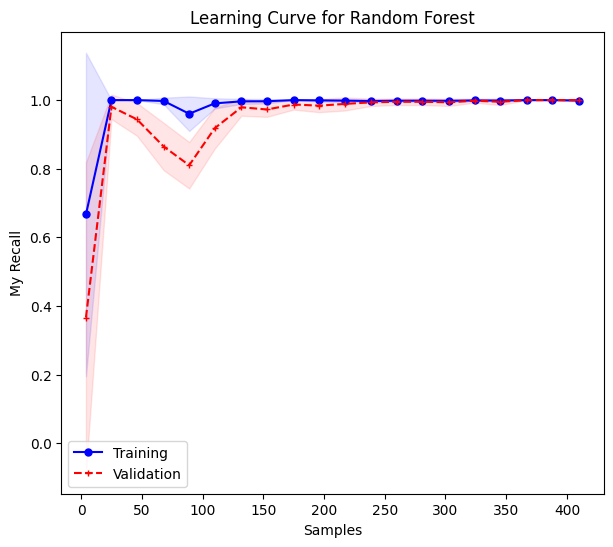

C:\Users\roroa\AppData\Local\Temp\ipykernel_8140\630914.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Recall score: 1.0000


C:\Users\roroa\AppData\Local\Temp\ipykernel_8140\630914.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


In [24]:
delta_a = np.linspace(0.01, 1, 20)

model = RandomForestClassifier(
    ccp_alpha=0.001, 
    criterion="gini",    
    max_depth=3, 
    min_samples_split=3
)
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train,
    np.ravel(y_train),
    train_sizes=delta_a,
    cv=cv,
    scoring=make_scorer(my_recall),
    n_jobs=-1
    # error_score="raise"
)

mi_LearningCurvePlot(train_sizes, train_scores, test_scores,
                     title="Learning Curve for Random Forest",
                     xlabel="Samples",
                     ylabel="My Recall"
                    )

evaluate_metrics(model, X_train, y_train, X_test, y_test, 'recall') 